In [1]:
# !pip uninstall tensorflow
# !pip3 install --upgrade tensorflow-gpu
# # !pip install --upgrade tensorflow-gpu
# !pip install grpcio>=1.24.3 --upgrade
# # !pip install -U keras-tuner
# !pip install tensorflow-addons
#!pip install keras-rectified-adam

In [1]:
#%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

/home/sde/.local/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Found GPU at: /device:GPU:0


In [2]:
import os
os.environ['TF_KERAS'] = '1'
!echo $TF_KERAS

1


In [3]:
from keras_radam import RAdam

In [4]:
import IPython.display as ipd

In [5]:
import librosa
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import IPython.display as ipd
import librosa.display
import scipy
import glob
import numpy as np
import math
import warnings
import pickle
from sklearn.utils import shuffle

# Load the TensorBoard notebook extension.
%load_ext tensorboard

/home/sde/.local/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/sde/.local/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13265657493268184493,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9416234222159695094
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1700725470079842760
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5456313728
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4808891255939595161
 physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [7]:
tf.random.set_seed(999)
np.random.seed(999)

In [8]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
#!ls 'drive/My Drive/datasets/tf_records'

train_0.tfrecords   train_1.tfrecords  train_5.tfrecords  train_9.tfrecords
train_10.tfrecords  train_2.tfrecords  train_6.tfrecords  val_0.tfrecords
train_11.tfrecords  train_3.tfrecords  train_7.tfrecords
train_12.tfrecords  train_4.tfrecords  train_8.tfrecords


In [10]:
train_tfrecords_filenames = glob.glob('drive/My Drive/datasets/tf_records/train_*')
np.random.shuffle(train_tfrecords_filenames)
train_tfrecords_filenames = list(train_tfrecords_filenames)
print(train_tfrecords_filenames)
val_tfrecords_filenames = glob.glob('drive/My Drive/datasets/tf_records/val_*')

['drive/My Drive/datasets/tf_records/train_2.tfrecords', 'drive/My Drive/datasets/tf_records/train_4.tfrecords', 'drive/My Drive/datasets/tf_records/train_11.tfrecords', 'drive/My Drive/datasets/tf_records/train_6.tfrecords', 'drive/My Drive/datasets/tf_records/train_12.tfrecords', 'drive/My Drive/datasets/tf_records/train_7.tfrecords', 'drive/My Drive/datasets/tf_records/train_9.tfrecords', 'drive/My Drive/datasets/tf_records/train_3.tfrecords', 'drive/My Drive/datasets/tf_records/train_10.tfrecords', 'drive/My Drive/datasets/tf_records/train_8.tfrecords', 'drive/My Drive/datasets/tf_records/train_1.tfrecords', 'drive/My Drive/datasets/tf_records/train_5.tfrecords', 'drive/My Drive/datasets/tf_records/train_0.tfrecords']


In [8]:
windowLength = 256
overlap      = round(0.25 * windowLength) # overlap of 75%
ffTLength    = windowLength
inputFs      = 48e3
fs           = 16e3
numFeatures  = ffTLength//2 + 1
numSegments  = 8
print("windowLength:",windowLength)
print("overlap:",overlap)
print("ffTLength:",ffTLength)
print("inputFs:",inputFs)
print("fs:",fs)
print("numFeatures:",numFeatures)
print("numSegments:",numSegments)

windowLength: 256
overlap: 64
ffTLength: 256
inputFs: 48000.0
fs: 16000.0
numFeatures: 129
numSegments: 8


In [0]:
mozilla_basepath = 'drive/My Drive/datasets/en'
UrbanSound8K_basepath = 'drive/My Drive/datasets/UrbanSound8K'

## Prepare Input features

In [0]:
def tf_record_parser(record):
    keys_to_features = {
        "noise_stft_phase": tf.io.FixedLenFeature((), tf.string, default_value=""),
        'noise_stft_mag_features': tf.io.FixedLenFeature([], tf.string),
        "clean_stft_magnitude": tf.io.FixedLenFeature((), tf.string)
    }

    features = tf.io.parse_single_example(record, keys_to_features)

    noise_stft_mag_features = tf.io.decode_raw(features['noise_stft_mag_features'], tf.float32)
    clean_stft_magnitude = tf.io.decode_raw(features['clean_stft_magnitude'], tf.float32)
    noise_stft_phase = tf.io.decode_raw(features['noise_stft_phase'], tf.float32)

    # reshape input and annotation images
    noise_stft_mag_features = tf.reshape(noise_stft_mag_features, (129, 8, 1), name="noise_stft_mag_features")
    clean_stft_magnitude = tf.reshape(clean_stft_magnitude, (129, 1, 1), name="clean_stft_magnitude")
    noise_stft_phase = tf.reshape(noise_stft_phase, (129,), name="noise_stft_phase")

    return noise_stft_mag_features, clean_stft_magnitude

## Create tf.Data.Dataset

In [0]:
train_dataset = tf.data.TFRecordDataset([train_tfrecords_filenames])
train_dataset = train_dataset.map(tf_record_parser)
train_dataset = train_dataset.shuffle(8192)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(512+256)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [0]:
test_dataset = tf.data.TFRecordDataset([val_tfrecords_filenames])
test_dataset = test_dataset.map(tf_record_parser)
test_dataset = test_dataset.repeat(1)
test_dataset = test_dataset.batch(512)

## Model Training

In [9]:
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras import Model, Sequential

In [10]:
def conv_block(x, filters, kernel_size, strides, padding='same', use_bn=True):
  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(0.0006))(x)
  x = Activation('relu')(x)
  if use_bn:
    x = BatchNormalization()(x)
  return x

In [11]:
def full_pre_activation_block(x, filters, kernel_size, strides, padding='same', use_bn=True):
  shortcut = x
  in_channels = x.shape[-1]

  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)

  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=in_channels, kernel_size=kernel_size, strides=strides, padding='same')(x)

  return shortcut + x

In [12]:
def build_model(l2_strength):
  inputs = Input(shape=[numFeatures,numSegments,1])
  x = inputs

  # -----
  x = tf.keras.layers.ZeroPadding2D(((4,4), (0,0)))(x)
  x = Conv2D(filters=18, kernel_size=[9,8], strides=[1, 1], padding='valid', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  skip0 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(skip0)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # -----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  skip1 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(skip1)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)
  
  x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
             kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = x + skip1
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
             kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = x + skip0
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = tf.keras.layers.SpatialDropout2D(0.2)(x)
  x = Conv2D(filters=1, kernel_size=[129,1], strides=[1, 1], padding='same')(x)

  model = Model(inputs=inputs, outputs=x)

  optimizer = tf.keras.optimizers.Adam(3e-4)
  #optimizer = RAdam(total_steps=10000, warmup_proportion=0.1, min_lr=3e-4)

  model.compile(optimizer=optimizer, loss='mse', 
                metrics=[tf.keras.metrics.RootMeanSquaredError('rmse')])
  return model

In [13]:
model = build_model(l2_strength=0.0)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 129, 8, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 137, 8, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 129, 1, 18)   1296        zero_padding2d[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 129, 1, 18)   0           conv2d[0][0]                     
______________________________________________________________________________________________

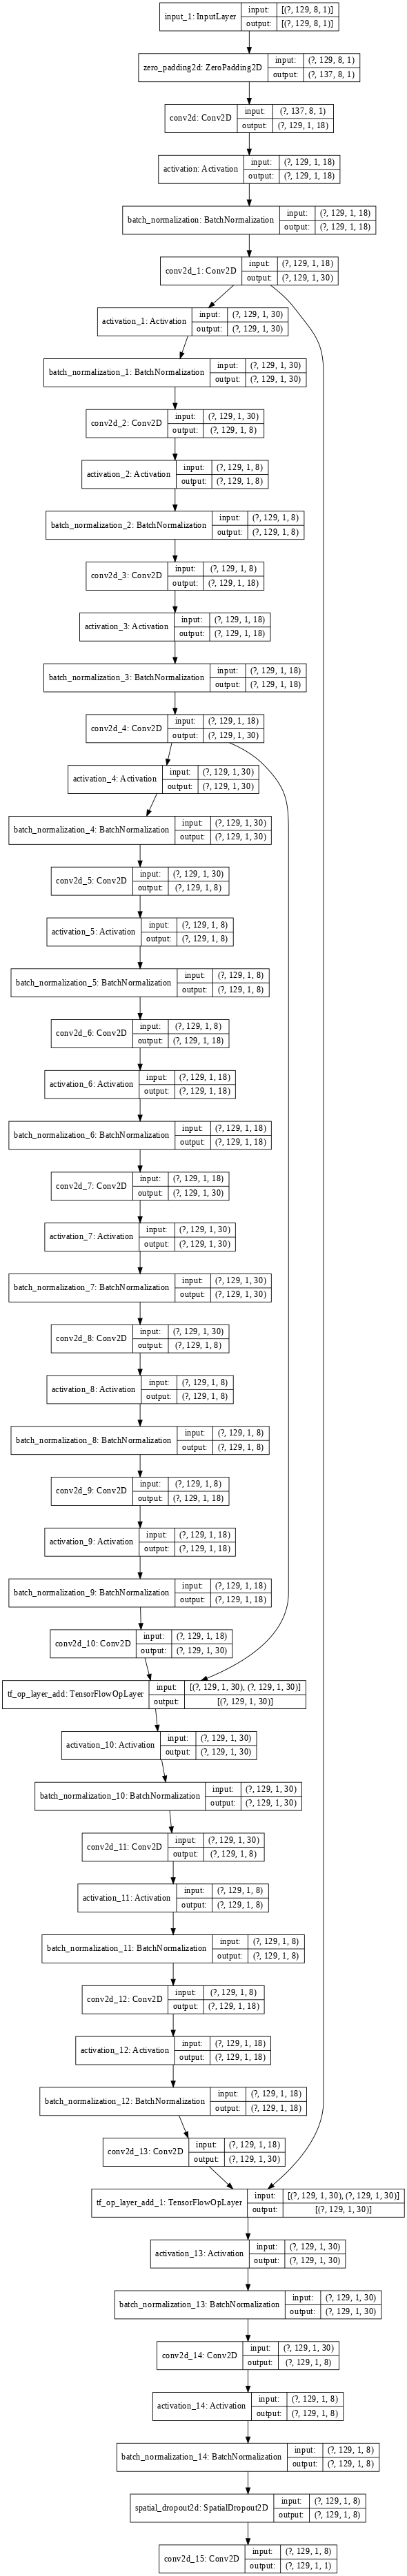

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [22]:
%tensorboard --logdir logs

In [23]:
model.load_weights('drive/My Drive/datasets/dataset_v2/denoiser_cnn_log_mel_generator.h5')
baseline_val_loss = model.evaluate(test_dataset)[0]
print(baseline_val_loss)

393/393 [==============================] - 16s 40ms/step - loss: 0.1433 - rmse: 0.3785
0.1433279666073298


In [0]:
def l2_norm(vector):
    return np.square(vector)

def SDR(denoised, cleaned, eps=1e-7): # Signal to Distortion Ratio
    a = l2_norm(denoised)
    b = l2_norm(denoised - cleaned)
    a_b = a / b
    return np.mean(10 * np.log10(a_b + eps))

In [0]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, baseline=baseline_val_loss)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, update_freq='batch')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='drive/My Drive/datasets/dataset_v2/denoiser_cnn_log_mel_generator.h5', 
                                                         monitor='val_loss', save_best_only=True)

model.fit(train_dataset,
         steps_per_epoch=600,
         validation_data=test_dataset,
         epochs=9999,
         callbacks=[early_stopping_callback, tensorboard_callback, checkpoint_callback]
        )

Train for 600 steps
Epoch 1/9999
600/600 [==============================] - 56s 93ms/step - loss: 0.1456 - rmse: 0.3816 - val_loss: 0.1469 - val_rmse: 0.3831
Epoch 2/9999
600/393 [=============================================] - 57s 95ms/step - loss: 0.1461 - rmse: 0.3806 - val_loss: 0.1483 - val_rmse: 0.3850
Epoch 3/9999
600/393 [=============================================] - 59s 98ms/step - loss: 0.1437 - rmse: 0.3836 - val_loss: 0.1452 - val_rmse: 0.3810
Epoch 4/9999
600/393 [=============================================] - 62s 104ms/step - loss: 0.1475 - rmse: 0.3795 - val_loss: 0.1495 - val_rmse: 0.3866
Epoch 5/9999
600/393 [=============================================] - 76s 126ms/step - loss: 0.1432 - rmse: 0.3792 - val_loss: 0.1442 - val_rmse: 0.3798
Epoch 6/9999
600/393 [=============================================] - 65s 109ms/step - loss: 0.1388 - rmse: 0.3769 - val_loss: 0.1494 - val_rmse: 0.3864
Epoch 7/9999
600/393 [=============================================] - 60s

In [0]:
# val_loss = model.evaluate(test_dataset)[0]
# if val_loss < baseline_val_loss:
#   print("New .model saved")
#   model.save('drive/My Drive/datasets/dataset_v2/denoiser_cnn_log_mel_generator.h5')

In [0]:
# model.save('drive/My Drive/datasets/dataset_v2/denoiser_cnn_generator.h5')
# model.load_weights('drive/My Drive/datasets/one_noise_data/model.h5')

In [14]:
model.load_weights('/home/sde/Desktop/projects/Egg-Shaped_Apostle/services/audio_service/noise_suppression/cnn/dataset_v2/denoiser_cnn_generator.h5')

## Testing

In [16]:
def read_audio(filepath, sample_rate, normalize=True):
    # print(f"Reading: {filepath}").
    audio, sr = librosa.load(filepath, sr=sample_rate)
    if normalize:
      div_fac = 1 / np.max(np.abs(audio)) / 3.0
      audio = audio * div_fac
    return audio, sr
        
def add_noise_to_clean_audio(clean_audio, noise_signal):
    if len(clean_audio) >= len(noise_signal):
        # print("The noisy signal is smaller than the clean audio input. Duplicating the noise.")
        while len(clean_audio) >= len(noise_signal):
            noise_signal = np.append(noise_signal, noise_signal)

    ## Extract a noise segment from a random location in the noise file
    ind = np.random.randint(0, noise_signal.size - clean_audio.size)

    noiseSegment = noise_signal[ind: ind + clean_audio.size]

    speech_power = np.sum(clean_audio ** 2)
    noise_power = np.sum(noiseSegment ** 2)
    noisyAudio = clean_audio + np.sqrt(speech_power / noise_power) * noiseSegment
    return noisyAudio

def play(audio, sample_rate):
    ipd.display(ipd.Audio(data=audio, rate=sample_rate))  # load a local WAV file

In [17]:
class FeatureExtractor:
    def __init__(self, audio, *, windowLength, overlap, sample_rate):
        self.audio = audio
        self.ffT_length = windowLength
        self.window_length = windowLength
        self.overlap = overlap
        self.sample_rate = sample_rate
        self.window = scipy.signal.hamming(self.window_length, sym=False)

    def get_stft_spectrogram(self):
        return librosa.stft(self.audio, n_fft=self.ffT_length, win_length=self.window_length, hop_length=self.overlap,
                            window=self.window, center=True)

    def get_audio_from_stft_spectrogram(self, stft_features):
        return librosa.istft(stft_features, win_length=self.window_length, hop_length=self.overlap,
                             window=self.window, center=True)

    def get_mel_spectrogram(self):
        return librosa.feature.melspectrogram(self.audio, sr=self.sample_rate, power=2.0, pad_mode='reflect',
                                           n_fft=self.ffT_length, hop_length=self.overlap, center=True)

    def get_audio_from_mel_spectrogram(self, M):
        return librosa.feature.inverse.mel_to_audio(M, sr=self.sample_rate, n_fft=self.ffT_length, hop_length=self.overlap,
                                             win_length=self.window_length, window=self.window,
                                             center=True, pad_mode='reflect', power=2.0, n_iter=32, length=None)

In [21]:
cleanAudio, sr = read_audio('/home/sde/Desktop/projects/Egg-Shaped_Apostle/services/audio_service/noise_suppression/cnn/2_1_0_2020-03-24T17_35_33.077595.wav', sample_rate=fs)
ipd.Audio(data=cleanAudio, rate=sr) # load a local WAV file

In [15]:
cleanAudio, sr = read_audio(os.path.join(mozilla_basepath, 'clips', 'test', 'common_voice_en_16526.mp3'), sample_rate=44100)
print("Min:", np.min(cleanAudio),"Max:",np.max(cleanAudio))
ipd.Audio(data=cleanAudio, rate=sr) # load a local WAV file

NameError: name 'read_audio' is not defined

In [0]:
noiseAudio, sr = read_audio(os.path.join(UrbanSound8K_basepath, 'audio', 'fold10', '7913-3-0-0.wav'), sample_rate=fs)
print("Min:", np.min(noiseAudio),"Max:",np.max(noiseAudio))
ipd.Audio(data=noiseAudio, rate=sr) # load a local WAV file

In [22]:
cleanAudioFeatureExtractor = FeatureExtractor(cleanAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
stft_features = cleanAudioFeatureExtractor.get_stft_spectrogram()
stft_features = np.abs(stft_features)
print("Min:", np.min(stft_features),"Max:",np.max(stft_features))

Min: 2.084595e-08 Max: 7.684162


In [0]:
noisyAudio = add_noise_to_clean_audio(cleanAudio, noiseAudio)
ipd.Audio(data=noisyAudio, rate=fs) # load a local WAV file

In [23]:
noisyAudio = cleanAudio

In [24]:
def prepare_input_features(stft_features):
    # Phase Aware Scaling: To avoid extreme differences (more than
    # 45 degree) between the noisy and clean phase, the clean spectral magnitude was encoded as similar to [21]:
    noisySTFT = np.concatenate([stft_features[:,0:numSegments-1], stft_features], axis=1)
    stftSegments = np.zeros((numFeatures, numSegments , noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:,:,index] = noisySTFT[:,index:index + numSegments]
    return stftSegments

In [25]:
noiseAudioFeatureExtractor = FeatureExtractor(noisyAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
noise_stft_features = noiseAudioFeatureExtractor.get_stft_spectrogram()

# Paper: Besides, spectral phase was not used in the training phase.
# At reconstruction, noisy spectral phase was used instead to
# perform in- verse STFT and recover human speech.
noisyPhase = np.angle(noise_stft_features)
print(noisyPhase.shape)
noise_stft_features = np.abs(noise_stft_features)

mean = np.mean(noise_stft_features)
std = np.std(noise_stft_features)
noise_stft_features = (noise_stft_features - mean) / std

(129, 7501)


In [26]:
predictors = prepare_input_features(noise_stft_features)

In [27]:
predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], 1, predictors.shape[2]))
predictors = np.transpose(predictors, (3, 0, 1, 2)).astype(np.float32)
print('predictors.shape:', predictors.shape)

predictors.shape: (7501, 129, 8, 1)


In [28]:
STFTFullyConvolutional = model.predict(predictors)
print(STFTFullyConvolutional.shape)

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/conv2d/Conv2D (defined at <ipython-input-28-f2adffe2f11f>:1) ]] [Op:__inference_predict_function_2190]

Function call stack:
predict_function


In [0]:
def revert_features_to_audio(features, phase, cleanMean=None, cleanStd=None):
    # scale the outpus back to the original range
    if cleanMean and cleanStd:
        features = cleanStd * features + cleanMean

    phase = np.transpose(phase, (1, 0))
    features = np.squeeze(features)

    # features = librosa.db_to_power(features)
    features = features * np.exp(1j * phase)  # that fixes the abs() ope previously done

    features = np.transpose(features, (1, 0))
    return noiseAudioFeatureExtractor.get_audio_from_stft_spectrogram(features)

In [0]:
denoisedAudioFullyConvolutional = revert_features_to_audio(STFTFullyConvolutional, noisyPhase, mean, std)
print("Min:", np.min(denoisedAudioFullyConvolutional),"Max:",np.max(denoisedAudioFullyConvolutional))
ipd.Audio(data=denoisedAudioFullyConvolutional, rate=fs) # load a local WAV file

In [0]:
# A numeric identifier of the sound class -- Types of noise
# 0 = air_conditioner
# 1 = car_horn
# 2 = children_playing
# 3 = dog_bark
# 4 = drilling
# 5 = engine_idling
# 6 = gun_shot
# 7 = jackhammer
# 8 = siren
# 9 = street_music

In [0]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)

ax1.plot(cleanAudio)
ax1.set_title("Clean Audio")

ax2.plot(noisyAudio)
ax2.set_title("Noisy Audio")

ax3.plot(denoisedAudioFullyConvolutional)
ax3.set_title("Denoised Audio")